In [1]:
# import
import glob
import numpy as np


import numpy as np
import pandas as pd
import sys
# import seaborn as sns
from numpy import random

from matplotlib import pyplot as plt
import sys
import time
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# import original_data
import optuna
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, random_split

# config
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
EPOCHS = 800
N_FRAME = 12
TIME_LENGTH = 40
N_SAMPLE = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH = './data/timedt.data.400'


In [2]:
def get_original_data(
   path:str
):
    """
    input temperature : 温度
    
    return t, msd, csp, xyz, r_, v_xyz, v_, angle, g

    t       时间序列(单位:ps)
    msd     单He的msd(均方位移)
    csp     CSP(中心对称参数)
    xyz     单He的xyz坐标
    r_      单He离原点距离
    v_xyz   单He的沿xyz坐标的速度分量
    v_      单He的速度大小
    """
    with open(path, 'r', encoding='utf-8') as fin:
        t = []      # 时间序列(单位:ps)
        msd = []    # 单He的msd(均方位移)
        csp = []    # CSP(中心对称参数)
        xyz = []    # 单He的xyz坐标
        r_ = []     # 单He离原点距离
        v_xyz = []  # 单He的沿xyz坐标的速度分量
        v_ = []     # 单He的速度大小
        for i, line in enumerate(fin.readlines()[1:]):
            data = list(map(float, line.strip().split(' ')))
            t.append(data[0])
            msd.append(data[1])
            csp.append(data[2:8])
            xyz.append(data[8:11])
            r_.append(data[11])
            v_xyz.append(data[12:15])
            v_.append(data[15])

    # with open(G_PATH.format(Temperature=temperature), 'r', encoding='utf-8') as fin:
    #     g = []      # g参数
    #     for i, line in enumerate(fin.readlines()[1:]):
    #         data = list(map(float, line.strip().split(' ')))
    #         g.append(data[1:7])
    indices_to_remove = np.arange(1001, len(t) - 1, 1001)
    t = np.array(t)
    t = np.delete(t, indices_to_remove)
    t = t.reshape(-1, 1)
    msd = np.array(msd)
    msd = np.delete(msd, indices_to_remove)
    msd = msd.reshape(-1, 1)
    csp = np.array(csp)
    csp = np.delete(csp, indices_to_remove, axis=0)
    xyz = np.array(xyz)
    xyz = np.delete(xyz, indices_to_remove, axis=0)
    r_ = np.sqrt(np.array(r_))
    r_ = np.delete(r_, indices_to_remove)
    r_ = r_.reshape(-1, 1)
    v_xyz = np.array(v_xyz)
    v_xyz = np.delete(v_xyz, indices_to_remove, axis=0)
    v_ = np.sqrt(np.array(v_))
    v_ = np.delete(v_, indices_to_remove)
    v_ = v_.reshape(-1, 1)
    angle = np.arccos(v_xyz / v_.reshape(len(t), 1))
    # g = np.array(g)

    return t, msd, csp, xyz, r_, v_xyz, v_, angle# , g

In [3]:
class CNN(nn.Module):
    def __init__(
        self, 
        Channel_in, 
        Height_in, 
        Width_in,
        Embedding_list,
        Output_size, 
        Filter_num, 
        Kernel_list, 
        dropout = 0.5, 
    ):
        super(CNN, self).__init__()
        self.Embedding_list = Embedding_list
        self.emb = nn.ModuleList([
            nn.Sequential( nn.Linear(emb, Width_in),)
         for emb in Embedding_list])
        
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    Channel_in, 
                    Filter_num, 
                    kernel_size=(kernel, Width_in), 
                    padding=((kernel - 1) // 2, 0), 
                ),
                nn.ReLU(),
                nn.MaxPool2d(
                    kernel_size=((Height_in+3)//4, 1), 
                    stride=(Height_in+3)//4, 
                    padding=((Height_in-Height_in//4*4+1)//2, 0), 
                ), 
            )
            for kernel in Kernel_list
        ])
        # print(Kernel_list)
        self.fc = nn.Sequential(
            nn.Dropout(dropout), 
            nn.Linear(Filter_num * len(Kernel_list) * 4, 64),
            nn.ReLU(), 
            nn.Linear(64, 16), 
            nn.Linear(16, Output_size)
        )
        # one -hot 时就这样就行 output_size=4
        # self.output = nn.Sigmoid()

    def forward(self, x):
        x_list = []
        temp = 0
        for emb in self.Embedding_list:
            x_list.append(x[:,:,:,temp:temp+emb])
            temp = temp+emb
        embx = []
        for i, emb in enumerate(self.emb):
            embx.append(emb(x_list[i]))
        x = sum(tensor for tensor in embx)
        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1)
        out = out.view(x.size(0), -1)
        # print(out.shape)
        out = self.fc(out)
        # output = self.output(out)
        return out

In [4]:
model = CNN(1,TIME_LENGTH//2, 25, [1,6,4,4,3], 1, 8, [9,7,5,3], 0.5)

In [5]:
model.load_state_dict(torch.load('best_model_x.pth'))

<All keys matched successfully>

In [6]:
model.eval()

# 指定设备（如果需要）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (emb): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=25, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=6, out_features=25, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=4, out_features=25, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=4, out_features=25, bias=True)
    )
    (4): Sequential(
      (0): Linear(in_features=3, out_features=25, bias=True)
    )
  )
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(9, 25), stride=(1, 1), padding=(4, 0))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(5, 1), stride=5, padding=(0, 0), dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(7, 25), stride=(1, 1), padding=(3, 0))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(5, 1), stride=5, padding=(0, 0), dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 25), stride=

In [7]:
data = get_original_data(PATH)
y_true = data[5][:,1].reshape(-1,1)
data = np.hstack(data[1:])
INPUT_SIZE = data.shape[-1]
scaler = StandardScaler()
data = scaler.fit_transform(data)
y_true = scaler.fit_transform(y_true)
print(scaler.mean_)
print((scaler.var_)**0.5)
data_X = torch.from_numpy(data)
# print(data_X.shape)
data_Y = torch.from_numpy(y_true)
data_Y = data_Y.squeeze(1)
INPUT_SIZE = data.shape[-1]
data_num = len(range(TIME_LENGTH//2, len(data)-TIME_LENGTH//2))
X = torch.zeros(data_num, TIME_LENGTH//2, INPUT_SIZE)
Y = torch.zeros(data_num, 1)
i=0
for idx in range(TIME_LENGTH//2, len(data)-TIME_LENGTH//2):
    X[i, :, :] = data_X[idx-TIME_LENGTH//2 : idx]
    Y[i, :]    = data_Y[idx+TIME_LENGTH//2]#-data_Y[idx]
    i+=1
X = X.float().unsqueeze(1) # [Batch_size, C, H, W]
eval_generator = DataLoader(
        torch.utils.data.TensorDataset(X, Y), 
        BATCH_SIZE, 
        shuffle=False
    )


scores_list = []

for x, y in eval_generator:
    x = x.to(device)
    y = y.to(device)
    scores = model(x)
    scores_list.append(scores)
    
full_tensor = torch.cat(scores_list, dim=0)
full = full_tensor.to('cpu')
y_pred = full.detach().numpy()

[0.01902291]
[9.09201856]


In [8]:
np.save('x_true.npy', y_true)
np.save('x_pred.npy', y_pred)
# x的
# [0.05030058]
# [9.06335758]
# [0.01902291]
# [9.09201856]

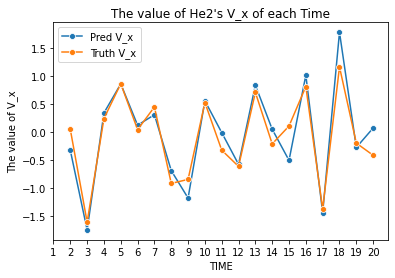

In [14]:
y_pred = np.load('x_pred.npy')
y_true = np.load('x_true.npy')
import seaborn as sns
df = pd.DataFrame({'train_loss': y_pred[800000:].ravel(), 'test_loss': y_true[800040:].ravel()})

df['index'] = range(len(df))
df['train_loss'] = df['train_loss'].rolling(window=5, center=True).mean()
df['test_loss'] = df['test_loss'].rolling(window=30, center=True).mean()
df =df.iloc[::10000]
sns.lineplot(data=df, x='index', y='test_loss', label='Pred V_x', marker='o')
sns.lineplot(data=df, x='index', y='train_loss', label='Truth V_x', marker='o')
plt.xlabel('TIME')
plt.ylabel('The value of V_x')
plt.xticks(ticks=df['index'], labels=[str(i) for i in range(1, 21)])
plt.title('The value of He2\'s V_x of each Time')
plt.savefig('./output/train_lot/x分量对比.png')

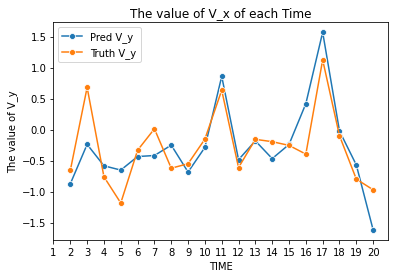

In [25]:
import seaborn as sns
df = pd.DataFrame({'train_loss': y_pred[800000:].ravel(), 'test_loss': y_true[800040:].ravel()})

df['index'] = range(len(df))
df['train_loss'] = df['train_loss'].rolling(window=5, center=True).mean()
df['test_loss'] = df['test_loss'].rolling(window=30, center=True).mean()
df =df.iloc[::10000]
sns.lineplot(data=df, x='index', y='test_loss', label='Pred V_y', marker='o')
sns.lineplot(data=df, x='index', y='train_loss', label='Truth V_y', marker='o')
plt.xlabel('TIME')
plt.ylabel('The value of V_y')
plt.xticks(ticks=df['index'], labels=[str(i) for i in range(1, 21)])
plt.title('The value of V_x of each Time')
# plt.savefig('./output/train_lot/y分量对比.png')

In [37]:
x_true = np.load('x_true.npy')
x_pred = np.load('x_pred.npy')
y_true = np.load('y_true.npy')
y_pred = np.load('y_pred.npy')
x_true = x_true[40:]
y_true = y_true[40:]

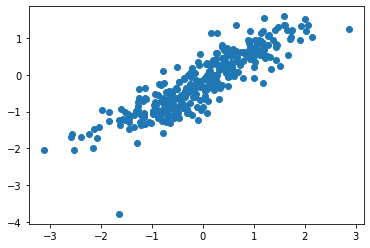

In [23]:
plt.scatter(x_true[::3000], x_pred[::3000])

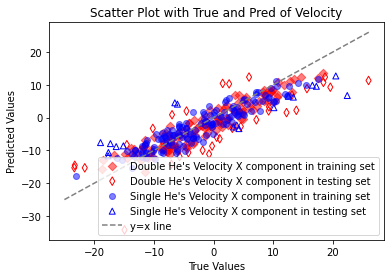

In [17]:
x_true = np.load('x_true.npy')
x_pred = np.load('x_pred.npy')
y_true = np.load('y_true.npy')
y_pred = np.load('y_pred.npy')
x_true = x_true[40:]
y_true = y_true[40:]

n = 6000
x_true = x_true[::n]
y_true = y_true[::n]
x_pred = x_pred[::n]
y_pred = y_pred[::n]
x_true = x_true*9.06335758 + 0.05030058
x_pred = x_pred*9.06335758 + 0.05030058
y_true = y_true* 9.09201856 + 0.01902291
y_pred = y_pred* 9.09201856 + 0.01902291
diff = np.abs(x_true - x_pred)
indices_of_big_diff = np.where(diff > 6)

x_true_filtered = [x for idx, x in enumerate(x_true) if idx not in indices_of_big_diff[0]]
x_pred_filtered = [y for idx, y in enumerate(x_pred) if idx not in indices_of_big_diff[0]]
plt.scatter(x_true_filtered, x_pred_filtered, marker='D', color='red',alpha=0.5, label='Double He\'s Velocity X component in training set')
plt.scatter(x_true[indices_of_big_diff[0]], x_pred[indices_of_big_diff[0]], 
            marker='d', facecolors='none', edgecolors='red', label='Double He\'s Velocity X component in testing set')


diff_y = np.abs(y_true - y_pred)
indices_of_big_diff_y = np.where(diff_y > 6)
selected_indices_y = indices_of_big_diff_y[0]
# num_to_draw_y = len(indices_of_big_diff_y[0])
# selected_indices_y = np.random.choice(indices_of_big_diff_y[0], num_to_draw_y, replace=False)
y_true_filtered = [y for idx, y in enumerate(y_true) if idx not in selected_indices_y]
y_pred_filtered = [p for idx, p in enumerate(y_pred) if idx not in selected_indices_y]
plt.scatter(y_true_filtered, y_pred_filtered, marker='o', color='blue', alpha=0.5, label='Single He\'s Velocity X component in training set')
plt.scatter(y_true[selected_indices_y], y_pred[selected_indices_y], 
            marker='^', facecolors='none', edgecolors='blue', label='Single He\'s Velocity X component in testing set')
min_x = int(np.floor(min(x_true)))
max_x = int(np.ceil(max(x_true)))
x_line = list(range(min_x - 1, max_x + 1))
y_line = x_line
plt.plot(x_line, y_line, '--', color='gray', label='y=x line')
plt.title('Scatter Plot with True and Pred of Velocity')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.savefig('对比图.png')
plt.show()

In [36]:
indices_of_big_diff[0]

array([], dtype=int64)